# Sequence to Sequence Learning with Neural Networks
___

This is a paper implementation in which I've tried to create the described model as closely as possible.
You may find some differences in the hyperparameters but that's mainly because I'm training the model on a small machine with $2$ GB VRAM.

I've tried to concisely describe the model architecture in section **Seq2Seq Model**, using quotes from the paper.

The model was trained for $5$ epochs with final validation loss of approx. $1.00$, but it isn't shown in this notebook, because of printing limitations. There is still one thing that has to be implemented and that's the calculation of *BLEU* score.

<small>Note: *Some special strings for start of sentence, end of sentence and padding do not appear on the Notebook after it's uploaded to Github - probably because the '\<' and '\>' symbols must be escaped*. Instead of them you'll see empty strings.</small>

## 1. Libraries

In [20]:
import os
import re
from typing import List

import spacy
import torch
import torchtext
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
from torchtext.data.metrics import bleu_score


# Controlling the randomness in PyTorch and NumPy.
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.benchmark = True
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

## 2. The Dataset
I've used a Kaggle dataset. You can download it from [here](https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench).

In [21]:
DATASET_PATH = os.path.join(
    "..", 
    "..", 
    "nlp", 
    "datasets", 
    "en-fr-translation", 
    "en-fr.csv"
)

df = pd.read_csv(DATASET_PATH)
df = df.rename(columns={"English words/sentences": "EN"})
df = df.rename(columns={"French words/sentences": "FR"})

df.head()

,EN,FR
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [22]:
def prepare_sentence(sentence: str):
    pattern = r"([.,!?:;]+)"
    sentence = re.sub(pattern, r" \1 ", sentence)

    pattern = r"\s+"
    sentence = re.sub(pattern, " ", sentence)

    return sentence

array([[<AxesSubplot:title={'center':'EN word count'}>,
        <AxesSubplot:title={'center':'FR word count'}>]], dtype=object)

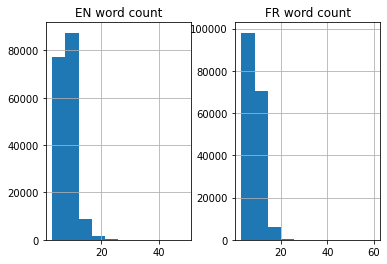

In [23]:
df["EN word count"] = df["EN"].apply(lambda x: len(prepare_sentence(x).split(" ")))
df["FR word count"] = df["FR"].apply(lambda x: len(prepare_sentence(x).split(" ")))
df.hist()

As we can see from the distributions, in both languages it would be okay to select $20$ as the max size of an input/output sequence.

In [24]:
# Shuffling and generating a subsample of the dataframe.
DATASET_FRACTION = 0.5
df = df.sample(frac=DATASET_FRACTION)

In [25]:
# You should first download these two spaCy models!
en_tokenizer = get_tokenizer("spacy", "en_core_web_sm")
fr_tokenizer = get_tokenizer("spacy", "fr_core_news_sm")

In [26]:
def iterate_corpus(corpus: List[str], tokenizer: spacy.tokenizer.Tokenizer, max_len: int):
    for sentence in corpus:
        tokens = tokenizer(
            prepare_sentence(sentence)
        )

        # Adding padding if it is needed.
        if len(tokens) >= max_len:
            tokens = tokens[:max_len]
        else:
            len_diff = max_len - len(tokens)
            tokens = tokens + ["<pad>"] * len_diff

        yield tokens


en_corpus = [sent for sent in list(df["EN"])]
fr_corpus = [sent for sent in list(df["FR"])]
EN_MAX_LEN = 20
FR_MAX_LEN = 20
SPECIALS = ["<unk>", "<start>", "<end>", "<pad>"]

en_vocab = build_vocab_from_iterator(
    iterate_corpus(en_corpus, en_tokenizer, EN_MAX_LEN), 
    specials=SPECIALS
)
en_vocab.set_default_index(en_vocab["<unk>"])

fr_vocab = build_vocab_from_iterator(
    iterate_corpus(fr_corpus, fr_tokenizer, FR_MAX_LEN), 
    specials=SPECIALS
)
fr_vocab.set_default_index(fr_vocab["<unk>"])

In [27]:
class TranslationDataset(Dataset):

    def __init__(
        self, 
        lang1_corpus: List[str], lang2_corpus: List[str],
        lang1_tokenizer: spacy.tokenizer.Tokenizer, lang2_tokenizer: spacy.tokenizer.Tokenizer,
        lang1_vocab: torchtext.vocab.Vocab, lang2_vocab: torchtext.vocab.Vocab,
        lang1_max_len: int = 200, lang2_max_len: int = 200, special_tokens=SPECIALS
    ):
        self.l1_corpus = lang1_corpus
        self.l2_corpus = lang2_corpus

        self.l1_max_len = lang1_max_len
        self.l2_max_len = lang2_max_len
        
        self.l1_tokenizer = lang1_tokenizer
        self.l2_tokenizer = lang2_tokenizer
        
        self.l1_vocab = lang1_vocab
        self.l2_vocab = lang2_vocab

        self.l1_token2idx = lang1_vocab
        self.l1_idx2token = {
            lang1_vocab[word]: word
            for sentence in lang1_corpus
            for word in lang1_tokenizer(prepare_sentence(sentence)) + SPECIALS
        }
        self.l2_token2idx = lang2_vocab
        self.l2_idx2token = {
            lang2_vocab[word]: word
            for sentence in lang2_corpus
            for word in lang2_tokenizer(prepare_sentence(sentence)) + SPECIALS
        }

        self.x, self.y = self._get_x_y()

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

    def _get_x_y(self):
        x = TranslationDataset._parse_corpus(
            self.l1_corpus, self.l1_tokenizer, self.l1_vocab, self.l1_max_len
        )
        y = TranslationDataset._parse_corpus(
            self.l2_corpus, self.l2_tokenizer, self.l2_vocab, self.l2_max_len
        )

        return x, y

    @staticmethod
    def _parse_corpus(
        corpus: List[str], 
        tokenizer: spacy.tokenizer.Tokenizer, 
        vocab: torchtext.vocab.Vocab,
        max_len: int
    ):
        output = []

        for sent in corpus:
            tokens = tokenizer(sent)
            indices = [vocab[token] for token in tokens]
            if len(indices) >= max_len:
                output.append([vocab["<start>"]] + indices[:max_len] + [vocab["<end>"]])
            else:
                len_diff = max_len - len(indices)
                padding = [vocab["<pad>"]] * len_diff
                output.append([vocab["<start>"]] + indices + [vocab["<end>"]] + padding)

        return torch.LongTensor(output)


dataset = TranslationDataset(
    lang1_corpus=en_corpus, lang2_corpus=fr_corpus,
    lang1_vocab=en_vocab, lang2_vocab=fr_vocab,
    lang1_tokenizer=en_tokenizer, lang2_tokenizer=fr_tokenizer,
    lang1_max_len=EN_MAX_LEN, lang2_max_len=FR_MAX_LEN
)
# Printing an example sentence, using the l1_idx2token dictionary.
# l1 here means language 1, which is English.
x_sample = dataset.x[1]
print("Using the 'l1_idx2token' attribute:")
print([dataset.l1_idx2token[int(idx)] for idx in x_sample])

print("x.shape:", dataset.x.shape)
print("y.shape:", dataset.y.shape)

Using the 'l1_idx2token' attribute:
['<start>', 'I', "'m", 'not', 'that', 'cynical', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
x.shape: torch.Size([87810, 22])
y.shape: torch.Size([87810, 22])


In [28]:
def train_validation_split(dataset: torch.utils.data.Dataset, train_size: float):
    train_set_size = int(len(dataset) * train_size)
    valid_set_size = len(dataset) - train_set_size
    datasets_lengths = [train_set_size, valid_set_size]

    # Splitting the input dataset into training and validation set.
    train_dataset, valid_dataset = random_split(dataset, datasets_lengths)

    return train_dataset, valid_dataset


train_dataset, valid_dataset = train_validation_split(
    dataset, train_size=0.8
)
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(valid_dataset))

Training dataset size: 70248
Validation dataset size: 17562


## 3. Seq2Seq Model
The model is constructed by two *LSTM*s - an *Encoder* and a *Decoder*.
- *Encoder* - takes the input sequence, projects it onto a certain space (embeds it), passes it through *LSTM* cells and returns the output and most importantly the *hidden state* that's going to be passed to the *Decoder*.
- *Decoder* - uses the *hidden state* from the *Encoder* and takes the target sequence (the expected output). On inference we only pass the '*\<start\>*' token and the model can be used by making 1-by-1 predictions. As an architecture it is almost the same as the *Encoder*, except for its last layer, which projects the output to $\mathbb{R}^{vocab}$ space - i.e. a vector of the size of the vocabulary (in our case it's the vocabulary of the French language).

An interesting thing that has been added by the creators of the paper is the reversal of the input sequence before it's passed to the *Encoder*:
> ... we found
> it extremely valuable to reverse the order of the words of the input sentence. So for example, instead
> of mapping the sentence a, b, c to the sentence α, β, γ, the LSTM is asked to map c, b, a to α, β, γ,
> where α, β, γ is the translation of a, b, c. This way, a is in close proximity to α, b is fairly close to β,
> and so on, a fact that makes it easy for SGD to “establish communication” between the input and the
> output. 

This may be seen in the `Seq2Seq` class, in `forward()`.

### 3.1. Encoder

In [29]:
class Encoder(nn.Module):

    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, num_layers: int, padding_idx: int):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.lstm = nn.LSTM(
            input_size=embed_size, 
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

    def forward(self, x: torch.Tensor, hidden: tuple):
        embedded_x = self.embed(x)
        hidden = [state.detach() for state in hidden]
        out, hidden = self.lstm(embedded_x, hidden)

        return out, hidden

    def get_init_hidden(self, batch_size):
        # See the PyTorch documentation of LSTM for these dimensions.
        h = torch.zeros(size=(self.num_layers, batch_size, self.hidden_size))
        c = torch.zeros(size=(self.num_layers, batch_size, self.hidden_size))

        return (h, c)


x = torch.randint(low=0, high=20, size=(10, 5))
enc = Encoder(vocab_size=50, embed_size=100, hidden_size=100, num_layers=4, padding_idx=0)
h, c = enc.get_init_hidden(10)
out, hidden = enc(x, (h, c))
print(f"Encoder output shape: {out.shape}")

Encoder output shape: torch.Size([10, 5, 100])


### 3.2. Decoder

In [30]:
class Decoder(nn.Module):

    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, num_layers: int, padding_idx: int):
        super().__init__()
        self.vocab_size = vocab_size

        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.lstm = nn.LSTM(
            input_size=embed_size, 
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, x: torch.Tensor, hidden: tuple):
        embedded_x = self.embed(x)
        hidden = [state.detach() for state in hidden]
        out, hidden = self.lstm(embedded_x, hidden)
        out = self.project(out)

        return out, hidden


# Passing through the Encoder
x = torch.randint(low=0, high=20, size=(10, 5))
enc = Encoder(vocab_size=50, embed_size=100, hidden_size=150, num_layers=4, padding_idx=0)
hidden = enc.get_init_hidden(10)
out, hidden = enc(x, hidden)
print(f"Encoder output shape: {out.shape}")
y = torch.randint(low=0, high=40, size=(10, 5))

# Passing through the Decoder
dec = Decoder(vocab_size=200, embed_size=120, hidden_size=150, num_layers=4, padding_idx=0)
out, hidden = dec(y, hidden)
print(f"Decoder output shape: {out.shape}")

Encoder output shape: torch.Size([10, 5, 150])
Decoder output shape: torch.Size([10, 5, 200])


### 3.3. Seq2Seq

In [31]:
class Seq2Seq(nn.Module):

    def __init__(self, encoder: torch.nn.Module, decoder: torch.nn.Module, reverse_input=True):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder

        self.reverse_input = reverse_input

    def forward(self, x: torch.Tensor, y: torch.Tensor, hidden: tuple):
        # Reversing the sequences in the input tensor.
        # In the paper it's stated that it is extremely valuable, and makes a difference.
        if self.reverse_input:
            x = torch.flip(x, [1])
        _, hidden = self.encoder(x, hidden)
        out, hidden = self.decoder(y, hidden)

        return out, hidden


# Input tensor:
x = torch.randint(low=0, high=20, size=(10, 5))
y = torch.randint(low=0, high=40, size=(10, 5))

# Defining the Encoder:
enc = Encoder(vocab_size=50, embed_size=100, hidden_size=150, num_layers=4, padding_idx=0)
init_hidden = enc.get_init_hidden(10)

# Defining the decoder:
dec = Decoder(vocab_size=100, embed_size=100, hidden_size=150, num_layers=4, padding_idx=0)

# Creating the Seq2Seq model:
model = Seq2Seq(encoder=enc, decoder=dec)
out, hidden = model(x, y, init_hidden)

print(f"Model:\n{model}")

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

print(f"Seq2Seq output shape: {out.shape}")
print(f"Seq2Seq hidden shape: {hidden[0].shape}")

Model:
Seq2Seq(
  (encoder): Encoder(
    (embed): Embedding(50, 100, padding_idx=0)
    (lstm): LSTM(100, 150, num_layers=4, batch_first=True)
  )
  (decoder): Decoder(
    (embed): Embedding(100, 100, padding_idx=0)
    (lstm): LSTM(100, 150, num_layers=4, batch_first=True)
    (project): Linear(in_features=150, out_features=100, bias=True)
  )
)
x shape: torch.Size([10, 5])
y shape: torch.Size([10, 5])
Seq2Seq output shape: torch.Size([10, 5, 100])
Seq2Seq hidden shape: torch.Size([4, 10, 150])


In [32]:
def initialize_weights(model: torch.nn.Module):
    """Initializing the weights with the uniform distribution between -0.08 and 
    0.08.

    Args:
        model (torch.nn.Module): The model for which the weights will be initialized.
    """
    for name, param in model.named_parameters():
        if "bias" in name or "weight" in name:
            torch.nn.init.uniform_(param, a=-0.08, b=0.08)

In [33]:
def save_checkpoint(model: torch.nn.Module, path: str):
    torch.save(model.state_dict(), path)


def load_checkpoint(model: torch.nn.Module, path: str):
    model.load_state_dict(torch.load(path))
    return model


MODEL_FILENAME = "1-seq2seq.pt"
MODEL_PATH = os.path.join("..", "models", MODEL_FILENAME)

## 4. Training
As for the training there are some differences between the paper and this implementation but they're insignificant.

In the paper they're using a *uniform distribution* for the weight initialization:
> We initialized all of the LSTM’s parameters with the uniform distribution between -0.08
> and 0.08

That's done in `initialize_weights()` above.


> We used stochastic gradient descent without momentum, with a fixed learning rate of 0.7.
> After 5 epochs, we begun halving the learning rate every half epoch. We trained our models
> for a total of 7.5 epochs.

I am using the SGD optimizer with learning rate of $0.7$ but I am not covering the halving of it on every half epoch.

> We used batches of 128 sequences

Here, I've used batch size of $64$ since my VRAM is not that up to par.

> Although LSTMs tend to not suffer from the vanishing gradient problem, they can have
> exploding gradients. Thus we enforced a hard constraint on the norm of the gradient [10,
> 25] by scaling it when its norm exceeded a threshold.

I am also clipping the gradients based on the norm - see `Seq2SeqTrainingSession._train_epoch()`. I've used the `torch.nn.utils.clip_grad_norm_()` method.

The model is also trained for $5$ epochs as it is stated in the paper.


In [34]:
class Seq2SeqTrainingSession:

    def __init__(
        self, 
        model: torch.nn.Module, 
        loss: torch.nn.Module, 
        optimizer: torch.optim.Optimizer,
        epochs: int, batch_size: int, 
        use_clipping=True,
        device="cpu"
    ):
        self.model = model
        self.loss_func = loss
        self.optimizer = optimizer

        self.epochs = epochs
        self.batch_size = batch_size

        self.use_clipping = use_clipping
        self.clip = 5
        self.device = device

    def start(
        self, 
        train_dataset: torch.utils.data.Subset, 
        valid_dataset: torch.utils.data.Subset,
        initial_hidden: torch.Tensor,
        l1_idx2token: dict,
        l2_idx2token: dict,
        fixed_sentences: List[List[str]] = None
    ):
        self.init_hidden = initial_hidden
        self.fixed_sentences = fixed_sentences

        self.l1_idx2token = l1_idx2token
        self.l2_idx2token = l2_idx2token
        
        train_dataloader = DataLoader(
            train_dataset, 
            self.batch_size, 
            shuffle=True, 
            num_workers=0,
            drop_last=True
        )
        valid_dataloader = DataLoader(
            train_dataset, 
            self.batch_size, 
            shuffle=True, 
            num_workers=0,
            drop_last=True
        )
        
        for epoch in range(self.epochs):
            train_loss, train_bleu = self._train_epoch(train_dataloader)
            valid_loss, valid_bleu = self._valid_epoch(valid_dataloader)
            print(f"Epoch: {epoch + 1}, Training Loss: {train_loss:.2f}, Train BLEU: {train_bleu:.2f}, Validation Loss: {valid_loss:.2f}, Validation BLEU: {valid_bleu:.2f}")

        return self.model

    def _train_epoch(self, dataloader):
        hidden = self.init_hidden

        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(self.device), y.to(self.device)

            y_pred, hidden = self.model(x, y, hidden)

            # Here y_pred should be trasformed to shape (BATCH_SIZE * SEQ_LEN, VOCAB_SIZE)
            # and y should be transformed to shape (BATCH_SIZE * SEQ_LEN).
            loss = self.loss_func(y_pred.reshape((-1, y_pred.shape[-1])), y.reshape(-1))
            self.optimizer.zero_grad()

            loss.backward()

            # Clipping the gradients, since LSTMs can have exploding gradients.
            if self.use_clipping:
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(), 
                    max_norm=self.clip
                )

            self.optimizer.step()

            if batch_i % 150 == 0:
                pred_sents, target_sents = self._tensors2sentences(y_pred[:1], y[:1])
                print(f"Training Batch {batch_i}, Loss: {loss.item():.2f}")
                bleu = self._calc_bleu(y_pred, y)
                print(f"Bleu Score: {bleu:.2f}")
                print("Example")
                print("-" * 100)
                print(f"Target: {' '.join(target_sents)}")
                print(f"Prediction: {' '.join(pred_sents)}")
                print("-" * 100)

                # Saving the model checkpoint.
                save_checkpoint(model=self.model, path=MODEL_PATH)

        epoch_loss = loss.item()
        epoch_bleu = self._calc_bleu(y_pred, y)

        return epoch_loss, epoch_bleu

    def _valid_epoch(self, dataloader):
        hidden = self.init_hidden

        self.model.eval()

        with torch.no_grad():
            for batch_i, (x, y) in enumerate(dataloader):
                x, y = x.to(self.device), y.to(self.device)
            
                y_pred, hidden = self.model(x, y, hidden)

                loss = self.loss_func(y_pred.reshape((-1, y_pred.shape[-1])), y.reshape(-1))

            epoch_loss = loss.item()
            epoch_bleu = self._calc_bleu(y_pred, y)

        self.model.train()
        
        return epoch_loss, epoch_bleu

    def _tensors2sentences(self, y_pred: torch.Tensor, y):
        predictions = y_pred.argmax(-1).tolist()
        targets = y.tolist()
        predictions = [
            self.l2_idx2token[idx] 
            for sent in predictions 
            for idx in sent
        ]
        targets = [
            self.l2_idx2token[idx] 
            for sent in targets 
            for idx in sent
        ]

        return predictions, targets

    def _calc_bleu(self, y_pred, y):
        predictions = y_pred.argmax(-1).tolist()
        targets = y.tolist()

        prediction_words = []
        target_words = []
        for i, (pred_sent, targ_sent) in enumerate(zip(predictions, targets)):
            prediction_words.append([])
            target_words.append([])
            for pred_idx, targ_idx in zip(pred_sent, targ_sent):
                prediction_words[i].append(self.l2_idx2token[pred_idx])
                target_words[i].append(self.l2_idx2token[targ_idx])

        return bleu_score(prediction_words, target_words)


# The paper uses 1000, but their dataset is huge.
EMBED_SIZE = 300
HIDDEN_SIZE = 512
NUM_LAYERS = 4
# The batch size was 128 in the paper, but my GPU has 2GB VRAM :[.
BATCH_SIZE = 64
L_RATE = 7e-1
# The epochs in the paper are 7.5 (7 epochs and a half).
# The model and the dataset are somewhat different, so I'll use different
# number of epochs.
EPOCHS = 5

LOAD_MODEL = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


enc = Encoder(
    vocab_size=len(en_vocab),
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    padding_idx=en_vocab["<pad>"]
)
init_hidden = enc.get_init_hidden(batch_size=BATCH_SIZE)
init_hidden = [h.to(DEVICE) for h in init_hidden]

dec = Decoder(
    vocab_size=len(fr_vocab),
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    padding_idx=fr_vocab["<pad>"]
)

model = Seq2Seq(
    encoder=enc, decoder=dec, 
    reverse_input=True
).to(DEVICE)

if LOAD_MODEL:
    model = load_checkpoint(model, path=MODEL_PATH)
else:
    model.apply(initialize_weights)

# The loss function and the optimizer.
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=L_RATE)

training_session = Seq2SeqTrainingSession(
    model=model,
    loss=loss,
    optimizer=optimizer,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    use_clipping=True,
    device=DEVICE
)
print(f"Device: {DEVICE}")
training_session.start(
    train_dataset=train_dataset, 
    valid_dataset=valid_dataset, 
    initial_hidden=init_hidden,
    l1_idx2token=dataset.l1_idx2token,
    l2_idx2token=dataset.l2_idx2token
)

Device: cuda
Training Batch 0, Loss: 9.89
Bleu Score: 0.00
Example
----------------------------------------------------------------------------------------------------
Target: <start> Tom t' aurait vraiment aimé . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Prediction: squatter tableau tableau tableau tableau tableau tableau tableau tableau tableau tableau tableau tableau tableau tableau tableau tableau tableau tableau tableau tableau tableau
----------------------------------------------------------------------------------------------------
Training Batch 150, Loss: 2.92
Bleu Score: 0.00
Example
----------------------------------------------------------------------------------------------------
Target: <start> Il essaya de rattraper le temps perdu . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Prediction: <start> <start> Je est . . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

Seq2Seq(
  (encoder): Encoder(
    (embed): Embedding(12515, 300, padding_idx=3)
    (lstm): LSTM(300, 512, num_layers=4, batch_first=True)
  )
  (decoder): Decoder(
    (embed): Embedding(20099, 300, padding_idx=3)
    (lstm): LSTM(300, 512, num_layers=4, batch_first=True)
    (project): Linear(in_features=512, out_features=20099, bias=True)
  )
)